### PRESENTACIÓ: 
En aquest projecte, analitzaré un conjunt de dades de malalties cardíaques per desenvolupar un model predictiu que permeti determinar la presència de malaltia cardíaca en pacients. L'objectiu és utilitzar tècniques de machine learning per ajudar en el diagnòstic precoç de malalties cardíaques, millorant així la prevenció i la intervenció mèdica.

El conjunt de dades utilitzat és el "Conjunto de datos de enfermedades cardíacas" de Kaggle, que inclou informació de pacients de quatre bases de dades diferents: Cleveland, Hongria, Suïssa i Long Beach V.


### DESCRIPCIÓ DE LES DADES: 

Tot i que el conjunt de dades conté 76 atributs, utilitzarem un subconjunt de 14 atributs per a aquest projecte:

1. Edat: Edat del pacient en anys.
2. Sexe: Sexe del pacient (1 = masculí, 0 = femení).
3. Tipus de Dolor Toràcic: Classificació en 4 tipus de dolor toràcic.
4. Pressió Arterial en Repos: Mesura de la pressió arterial en repos en mm Hg.
5. Colesterol Sèric: Nivell de colesterol en sèrum en mg/dl.
6. Glucèmia en dejuni: Nivell de glucosa en sang en dejuni superior a 120 mg/dl.
7. Resultats Electrocardiogràfics en Repos: Valors de 0, 1 o 2 segons els resultats de l'ECG en repòs.
8. Freqüència Cardíaca Màxima Assolida: Freqüència cardíaca màxima assolida durant una prova d'esforç.
9. Angina Induïda per l'Exercici: Presència d'angina induïda per l'exercici (1 = sí, 0 = no).
10. Oldpeak: Depressió del segment ST induïda per l'exercici en relació amb el repòs.
11. Pendents del Segment ST: Inclinació del segment ST en el màxim exercici.
12. Nombre de Vasos Principals Colorejats per Fluoroscòpia: Nombre de vasos principals (0-3) colorejats.
13. Thal: 0 = normal; 1 = defecte reparat; 2 = defecte reversible.
14. Objectiu: Presència de malaltia cardíaca (0 = no, 1 = sí).


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Creació de la sessió de Spark
spark = SparkSession.builder.appName("Heart Disease Analysis").getOrCreate()

# Càrrega del conjunt de dades
data_path = "Malalties_cardiaques.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Mostra les primeres files
data.show(5)



+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
only showing top 5 rows



Vaig a comprovar el tipus de columna amb dtype.

In [2]:
print(data.dtypes)

[('age', 'int'), ('sex', 'int'), ('cp', 'int'), ('trestbps', 'int'), ('chol', 'int'), ('fbs', 'int'), ('restecg', 'int'), ('thalach', 'int'), ('exang', 'int'), ('oldpeak', 'double'), ('slope', 'int'), ('ca', 'int'), ('thal', 'int'), ('target', 'int')]


Totes les columnes són números sensers, excepte la columna de oldpeak que es tracta de decimals. 

In [3]:
# Canvi de nom variables al català.
data = data.select(
    col("age").alias("Edat"),
    col("sex").alias("Sexe"),
    col("cp").alias("Tipus de Dolor Toràcic"),
    col("trestbps").alias("Pressió Arterial en Repos"),
    col("chol").alias("Colesterol Sèric"),
    col("fbs").alias("Glucèmia en dejuni"),
    col("restecg").alias("Resultats Electrocardiogràfics en Repos"),
    col("thalach").alias("Freqüència Cardíaca Màxima Assolida"),
    col("exang").alias("Angina Induïda per l'Exercici"),
    col("oldpeak").alias("Oldpeak"),
    col("slope").alias("Pendents del Segment ST"),
    col("ca").alias("Nombre de Vasos Principals Colorejats per Fluoroscòpia"),
    col("thal").alias("Thal"),
    col("target").alias("Objectiu")
)

data.printSchema()
data.show(5)

root
 |-- Edat: integer (nullable = true)
 |-- Sexe: integer (nullable = true)
 |-- Tipus de Dolor Toràcic: integer (nullable = true)
 |-- Pressió Arterial en Repos: integer (nullable = true)
 |-- Colesterol Sèric: integer (nullable = true)
 |-- Glucèmia en dejuni: integer (nullable = true)
 |-- Resultats Electrocardiogràfics en Repos: integer (nullable = true)
 |-- Freqüència Cardíaca Màxima Assolida: integer (nullable = true)
 |-- Angina Induïda per l'Exercici: integer (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- Pendents del Segment ST: integer (nullable = true)
 |-- Nombre de Vasos Principals Colorejats per Fluoroscòpia: integer (nullable = true)
 |-- Thal: integer (nullable = true)
 |-- Objectiu: integer (nullable = true)

+----+----+----------------------+-------------------------+----------------+------------------+---------------------------------------+-----------------------------------+-----------------------------+-------+-----------------------+-----------

El que m'està dient és que totes les columnes permeten contenir valors nuls a més que l'estructura de les dades sòn correctes i podem procedir a l'EDA . 

### ANÀLISIS EXPLORATORI DE DADES (EDA): 

In [4]:
# Resum estadístic de les dades

data.describe().show()

+-------+-----------------+------------------+----------------------+-------------------------+-----------------+-------------------+---------------------------------------+-----------------------------------+-----------------------------+------------------+-----------------------+------------------------------------------------------+------------------+------------------+
|summary|             Edat|              Sexe|Tipus de Dolor Toràcic|Pressió Arterial en Repos| Colesterol Sèric| Glucèmia en dejuni|Resultats Electrocardiogràfics en Repos|Freqüència Cardíaca Màxima Assolida|Angina Induïda per l'Exercici|           Oldpeak|Pendents del Segment ST|Nombre de Vasos Principals Colorejats per Fluoroscòpia|              Thal|          Objectiu|
+-------+-----------------+------------------+----------------------+-------------------------+-----------------+-------------------+---------------------------------------+-----------------------------------+-----------------------------+---------

Resum estadístic, (això és el que m'està dient) 

count:

Edat: 1025
Sexe: 1025
Tipus de Dolor Toràcic: 1025
Pressió Arterial en Repos: 1025
Colesterol Sèric: 1025
Glucèmia en dejuni: 1025
Resultats Electrocardiogràfics en Repos: 1025
Freqüència Cardíaca Màxima Assolida: 1025
Angina Induïda per l'Exercici: 1025
Oldpeak: 1025
Pendents del Segment ST: 1025
Nombre de Vasos Principals Colorejats per Fluoroscòpia: 1025
Thal: 1025
Objectiu: 1025

Aquesta fila mostra el nombre de valors presents en cada columna. Totes les columnes tenen 1025 valors, el que significa que no hi ha valors nuls.

mean (mitjana):

Edat: 54.43
Sexe: 0.696
Tipus de Dolor Toràcic: 0.942
Pressió Arterial en Repos: 131.61
Colesterol Sèric: 246.0
Glucèmia en dejuni: 0.149
Resultats Electrocardiogràfics en Repos: 0.530
Freqüència Cardíaca Màxima Assolida: 149.11
Angina Induïda per l'Exercici: 0.337
Oldpeak: 1.072
Pendents del Segment ST: 1.385
Nombre de Vasos Principals Colorejats per Fluoroscòpia: 0.754
Thal: 2.324
Objectiu: 0.513


stddev (desviació estàndard):

Edat: 9.072
Sexe: 0.460
Tipus de Dolor Toràcic: 1.030
Pressió Arterial en Repos: 17.517
Colesterol Sèric: 51.593
Glucèmia en dejuni: 0.357
Resultats Electrocardiogràfics en Repos: 0.528
Freqüència Cardíaca Màxima Assolida: 23.006
Angina Induïda per l'Exercici: 0.473
Oldpeak: 1.175
Pendents del Segment ST: 0.618
Nombre de Vasos Principals Colorejats per Fluoroscòpia: 1.031
Thal: 0.621
Objectiu: 0.500

Aquesta fila mostra la desviació estàndard dels valors de cada columna. La desviació estàndard mesura la quantitat de variació o dispersió dels valors.

min (valor mínim):

Edat: 29
Sexe: 0
Tipus de Dolor Toràcic: 0
Pressió Arterial en Repos: 94
Colesterol Sèric: 126
Glucèmia en dejuni: 0
Resultats Electrocardiogràfics en Repos: 0
Freqüència Cardíaca Màxima Assolida: 71
Angina Induïda per l'Exercici: 0
Oldpeak: 0.0
Pendents del Segment ST: 0
Nombre de Vasos Principals Colorejats per Fluoroscòpia: 0
Thal: 0
Objectiu: 0

Aquesta fila mostra el valor mínim de cada columna.

max (valor màxim):

Edat: 77
Sexe: 1
Tipus de Dolor Toràcic: 3
Pressió Arterial en Repos: 200
Colesterol Sèric: 564
Glucèmia en dejuni: 1
Resultats Electrocardiogràfics en Repos: 2
Freqüència Cardíaca Màxima Assolida: 202
Angina Induïda per l'Exercici: 1
Oldpeak: 6.2
Pendents del Segment ST: 2
Nombre de Vasos Principals Colorejats per Fluoroscòpia: 4
Thal: 3
Objectiu: 1

Aquesta fila mostra el valor màxim de cada columna.

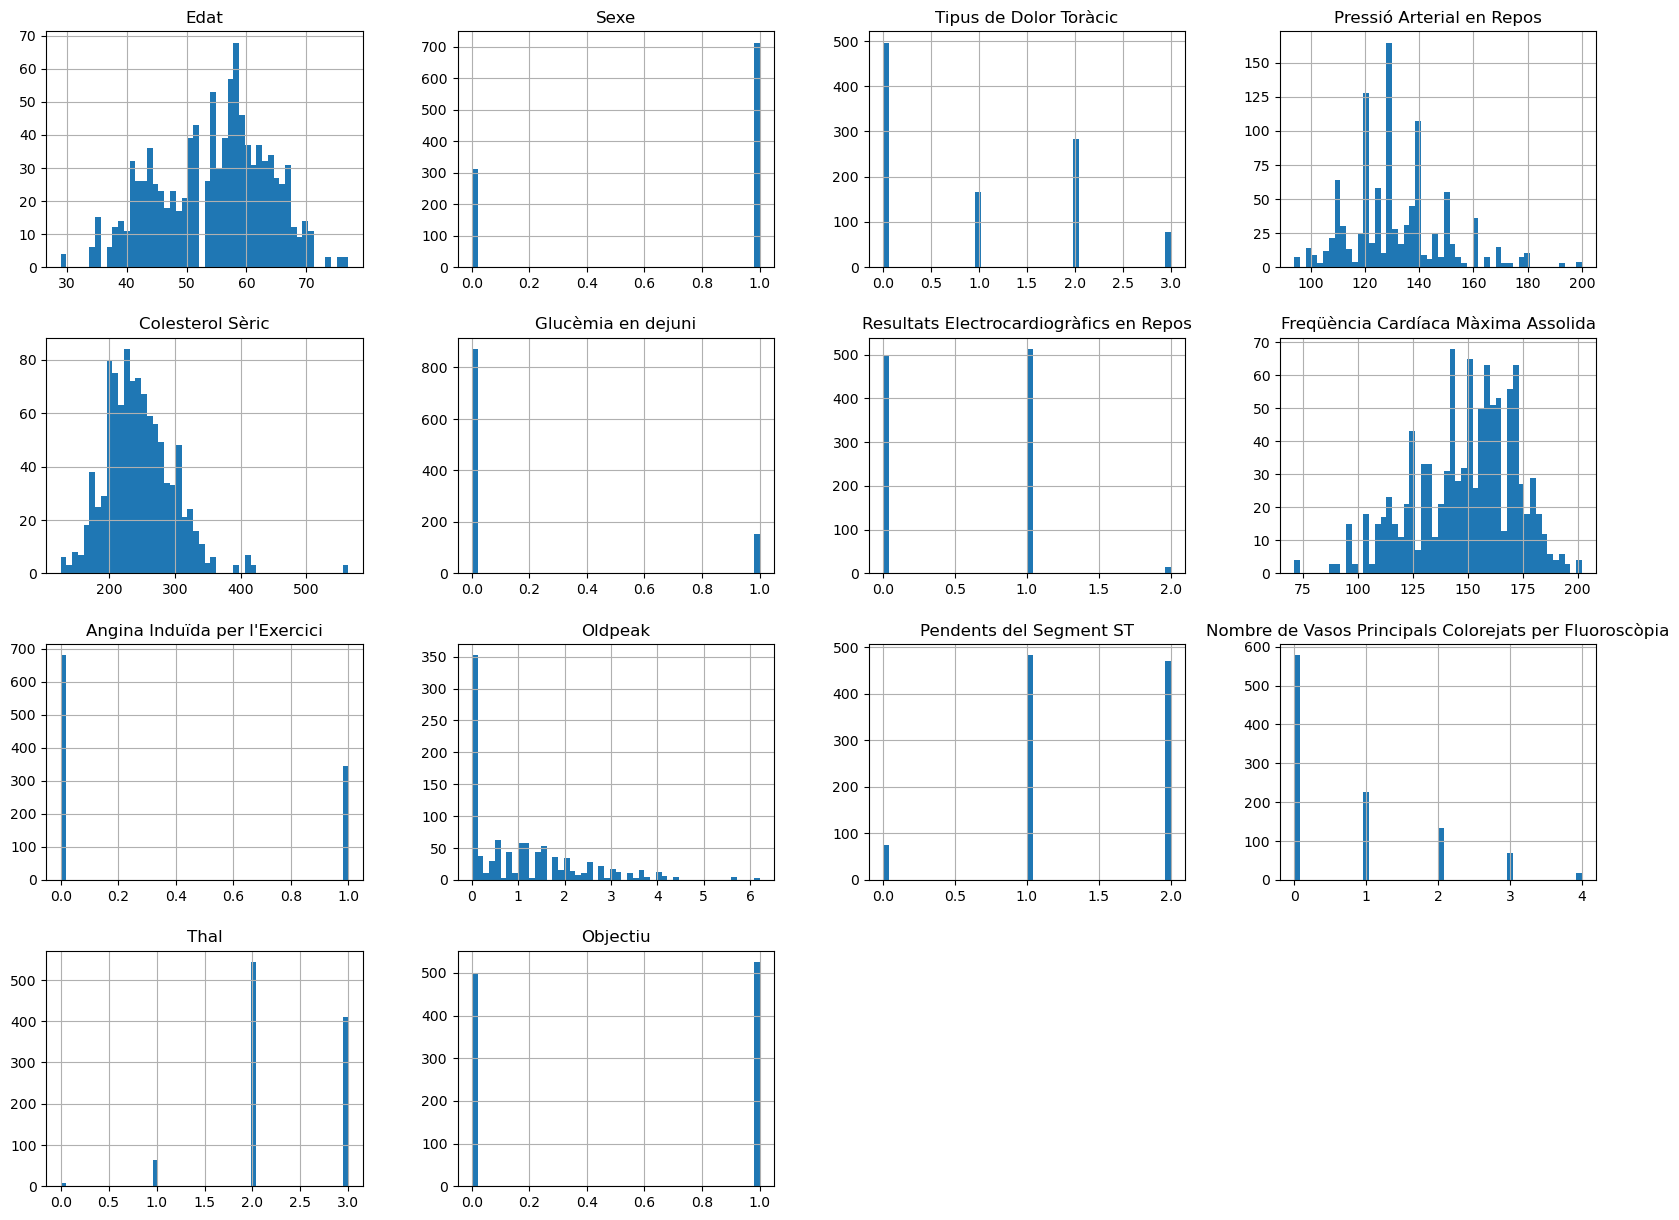

In [5]:
# Distribució de les variables 
import matplotlib.pyplot as plt
import pandas as pd

# Convertim les dades de  DataFrame a Pandas 
pandas_df = data.toPandas()

# Histogrames per a cada variable
pandas_df.hist(bins=50, figsize=(20,15))
plt.show()

Distribució del sexe: La majoria dels pacients són homes (70%), el que pot indicar una prevalença més alta de malalties cardíaques en homes en aquest conjunt de dades.

Edat dels pacients: La distribució de l'edat mostra que els pacients afectats per malalties cardíaques es troben principalment entre els 45 i 65 anys.

Pressió arterial i colesterol: Els pacients tenen una pressió arterial en repòs i nivells de colesterol sèric que van variant. La mitjana de colesterol és de 246, això m'indica que hi han molts pacients tenen nivells elevats de colesterol.

Freqüència cardíaca màxima: La mitjana de la freqüència cardíaca màxima assolida és de 149.11.

Angina induïda per l'exercici i oldpeak: Aproximadament un 34% dels pacients experimenten angina induïda per l'exercici, i el valor mitjà d'oldpeak és d'1.072.

Objectiu (presència de malaltia cardíaca): La variable d'objectiu básicament està distribuida entre els dos grups, però destaca una mica més els valors amb malaltia cardíaca.

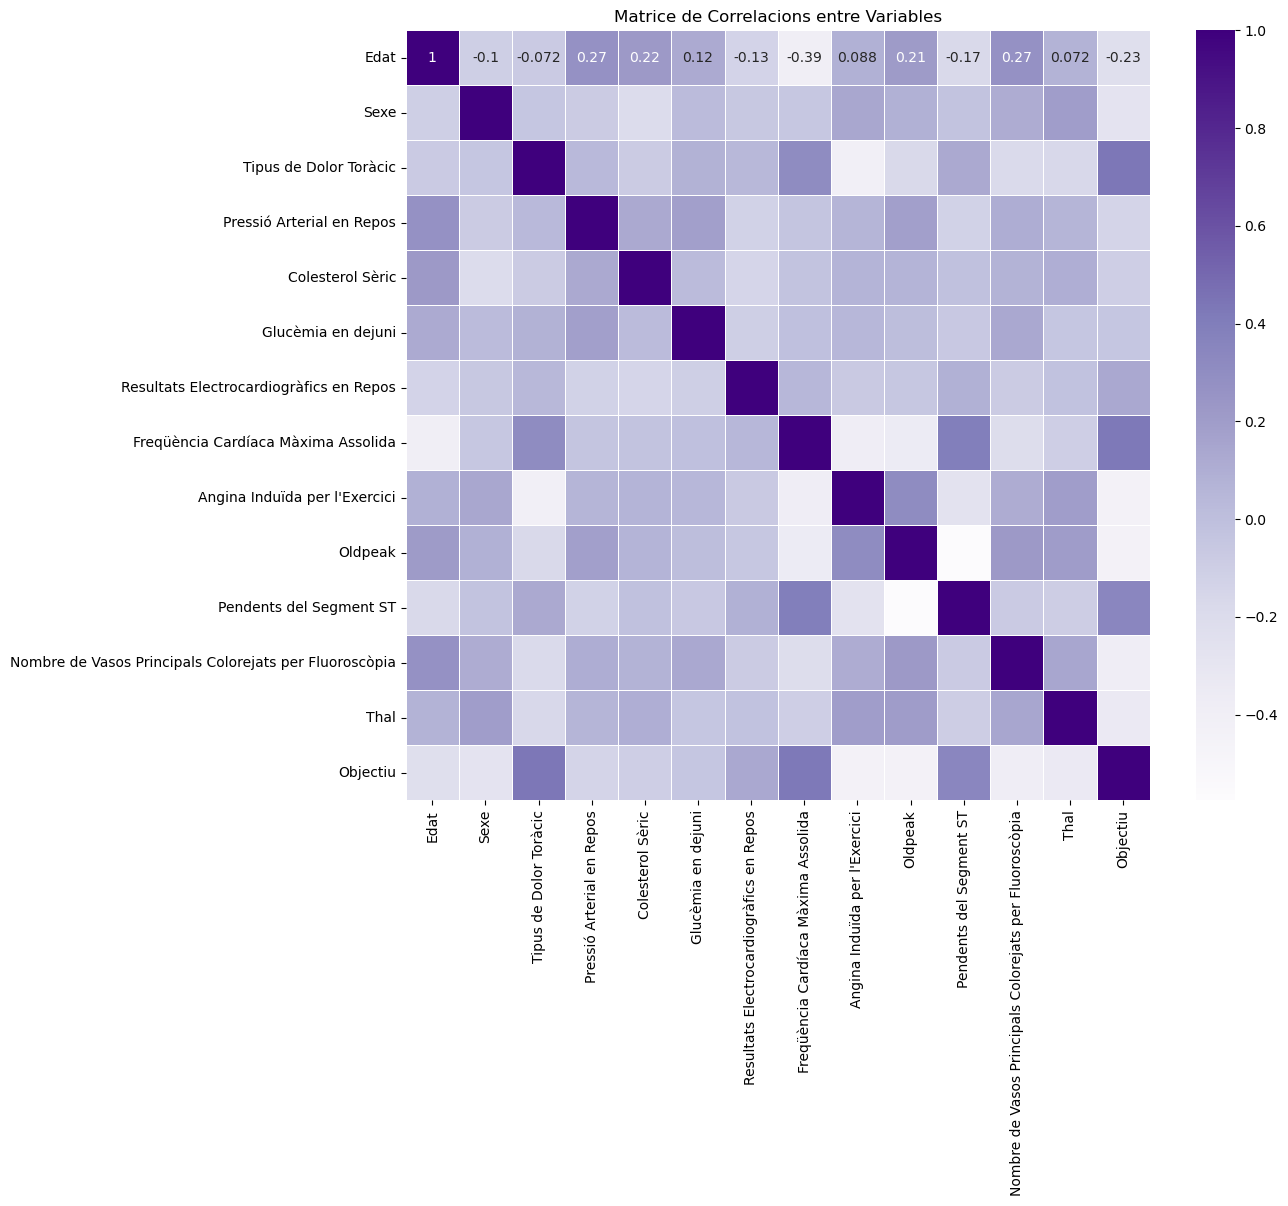

In [6]:
import seaborn as sns

# Correlacions entre variables
plt.figure(figsize=(12, 10))
correlation_matrix = pandas_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Purples', linewidths=0.5)
plt.title("Matrice de Correlacions entre Variables")
plt.show()

En la matriu de correlació, podem veure que la columna del nostre objectiu té molta correlació en el resultat per les variables tipus de dolor toracic, freqüència cardiaca máxima assolida, i pendents de segment ST. Això vol dir que són les variables que tenen més pes a l'hora de determinar si existeix enfermetat cardiaca o no. 

### PREPARACIÓ DE LES DADES: 

Com que les totes les variables tenen valors numérics només utilitzaré l'StandarScaler per escalar les característiques. També utilitzaré VectorAssembler per combinar les variables transformades en un vector únic anomenat "features". Aquest vector és el que s'utilitzarà per entrenar el model.

In [7]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Definir el VectorAssembler para crear el vector de características
assembler = VectorAssembler(
    inputCols=["Edat", "Sexe", "Tipus de Dolor Toràcic", "Pressió Arterial en Repos", "Colesterol Sèric",
               "Glucèmia en dejuni", "Resultats Electrocardiogràfics en Repos", 
               "Freqüència Cardíaca Màxima Assolida", "Angina Induïda per l'Exercici", "Oldpeak",
               "Pendents del Segment ST", "Nombre de Vasos Principals Colorejats per Fluoroscòpia", "Thal"],
    outputCol="features"
)
# StandardScaler para escalar las características
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Crear el pipeline de transformación
pipeline = Pipeline(stages=[assembler,scaler])

# Ajustar el pipeline a los datos
model = pipeline.fit(data)
data_prepared = model.transform(data)

# Seleccionar las columnas necesarias (características y objetivo)
final_data = data_prepared.select("features", "Objectiu")

final_data.show()

+--------------------+--------+
|            features|Objectiu|
+--------------------+--------+
|[52.0,1.0,0.0,125...|       0|
|[53.0,1.0,0.0,140...|       0|
|[70.0,1.0,0.0,145...|       0|
|[61.0,1.0,0.0,148...|       0|
|[62.0,0.0,0.0,138...|       0|
|(13,[0,3,4,7,9,10...|       1|
|[58.0,1.0,0.0,114...|       0|
|[55.0,1.0,0.0,160...|       0|
|[46.0,1.0,0.0,120...|       0|
|[54.0,1.0,0.0,122...|       0|
|[71.0,0.0,0.0,112...|       1|
|[43.0,0.0,0.0,132...|       0|
|[34.0,0.0,1.0,118...|       1|
|[51.0,1.0,0.0,140...|       0|
|[52.0,1.0,0.0,128...|       0|
|[34.0,0.0,1.0,118...|       1|
|[51.0,0.0,2.0,140...|       1|
|[54.0,1.0,0.0,124...|       0|
|[50.0,0.0,1.0,120...|       1|
|[58.0,1.0,2.0,140...|       1|
+--------------------+--------+
only showing top 20 rows



A partir d'aquí procedim a implementar el model de ML de Regresion logística. 

In [8]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Crear conjunto de entrenamiento y prueba (70% para entrenamiento y 30% para prueba)
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

# Definir el modelo de Regresión Logística
lr = LogisticRegression(featuresCol='features', labelCol='Objectiu')

# Crear un Pipeline con el modelo
pipeline = Pipeline(stages=[lr])

# Ajustar el modelo al conjunto de entrenamiento
model = pipeline.fit(train_data)

# Hacer predicciones sobre el conjunto de prueba
predictions = model.transform(test_data)

# Evaluar el rendimiento del modelo
evaluator = BinaryClassificationEvaluator(labelCol='Objectiu')
accuracy = evaluator.evaluate(predictions)

print(f"Exactitud (Accuracy) en el conjunto de prueba: {accuracy}")

Exactitud (Accuracy) en el conjunto de prueba: 0.9225937871329148


L'accuracy, em diu que el módel té un 92,3% de fiabilitat, no està malament, però és cert que s'hauria de millorar. Faig la comprovació amb el següent codi. 

In [9]:
# Seleccionar algunas columnas relevantes para visualizar
predictions.select('Objectiu', 'prediction', 'probability').show(50, truncate=False)

+--------+----------+------------------------------------------+
|Objectiu|prediction|probability                               |
+--------+----------+------------------------------------------+
|0       |1.0       |[0.35998028394552134,0.6400197160544787]  |
|1       |1.0       |[0.17924807296295325,0.8207519270370467]  |
|1       |1.0       |[0.17924807296295325,0.8207519270370467]  |
|1       |1.0       |[0.31653441954506223,0.6834655804549378]  |
|1       |1.0       |[0.005303459206501981,0.994696540793498]  |
|1       |1.0       |[0.005303459206501981,0.994696540793498]  |
|1       |1.0       |[0.008131835831886132,0.9918681641681139] |
|1       |1.0       |[0.012564307335316886,0.9874356926646831] |
|1       |1.0       |[0.044562587713392963,0.9554374122866071] |
|1       |1.0       |[0.044562587713392963,0.9554374122866071] |
|1       |1.0       |[0.03283289875306749,0.9671671012469325]  |
|1       |1.0       |[0.28022132224847696,0.719778677751523]   |
|1       |1.0       |[0.2

Podem veure que hi han dades que no les prediu com toca, vaig a mirar que passa si aplico el model RandomForest, ja que sol ser un dels que millor resultat donen. 

In [10]:
from pyspark.ml.classification import RandomForestClassifier

# VectorAssembler para crear el vector de características
assembler = VectorAssembler(inputCols=["features"], outputCol="features_vectorized")

# Modelo de Random Forest
rf = RandomForestClassifier(labelCol="Objectiu", featuresCol="features_vectorized", numTrees=100)

# Crear el Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Dividir datos en conjuntos de entrenamiento y prueba
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Ajustar el modelo utilizando el conjunto de entrenamiento
model = pipeline.fit(train_data)

# Hacer predicciones en el conjunto de prueba
predictions = model.transform(test_data)

# Evaluar el modelo utilizando un evaluador de clasificación binaria (ROC AUC)
evaluator = BinaryClassificationEvaluator(labelCol="Objectiu", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

# Mostrar el resultado del área bajo la curva ROC
print(f"Área bajo la curva ROC en el conjunto de prueba: {auc}")

Área bajo la curva ROC en el conjunto de prueba: 0.9807584269662922


In [11]:
# Seleccionar algunas columnas relevantes para visualizar
predictions.select('Objectiu', 'prediction', 'probability').show(50, truncate=False)

+--------+----------+-----------------------------------------+
|Objectiu|prediction|probability                              |
+--------+----------+-----------------------------------------+
|0       |0.0       |[0.551103904584931,0.44889609541506903]  |
|1       |1.0       |[0.11330664758456341,0.8866933524154367] |
|1       |1.0       |[0.11330664758456341,0.8866933524154367] |
|1       |1.0       |[0.06509094989831594,0.934909050101684]  |
|1       |1.0       |[0.11487443001364296,0.885125569986357]  |
|1       |1.0       |[0.12466067756054705,0.8753393224394529] |
|1       |1.0       |[0.2507549407726925,0.7492450592273076]  |
|1       |1.0       |[0.14034472608832518,0.8596552739116748] |
|0       |0.0       |[0.8026924250577204,0.19730757494227957] |
|0       |0.0       |[0.8026924250577204,0.19730757494227957] |
|0       |0.0       |[0.9176683464176177,0.08233165358238233] |
|0       |0.0       |[0.9176683464176177,0.08233165358238233] |
|1       |1.0       |[0.3883055579037077

### ANÀLISIS DE LA INFORMACIÓ ESTRETA: 

Després d'entrenar i avaluar dos models de classificació diferents (Regressió Logística i Random Forest), podem fer una comparació del seu rendiment en la predicció de malalties cardíaques.

Observo que les variables més significatives per a la predicció de malalties cardíaques inclouen:

- Edat
- Tipus de Dolor Toràcic
- Freqüència Cardíaca Màxima Assolida
- Oldpeak

#### Resultats de la Regressió Logística
Després d'entrenar el model de regressió logística, he obtingut els seüents resultats:

Exactitud (Accuracy)
L'exactitud en el conjunt de prova és del 92,26%. Aquest valor indica que el model té una bona capacitat de discriminació entre pacients amb i sense malaltia cardíaca, #### tot i que hi ha marge per millorar el rendiment.

#### Resultats de Random Forest
Després d'entrenar el model de Random Forest, hem obtingut els següents resultats:

Àrea sota la corba ROC (AUC)
L'àrea sota la corba ROC en el conjunt de prova és de 0.979. Aquest valor indica que el model té una excel·lent capacitat de discriminació entre pacients amb i sense malaltia cardíaca.
  


### CONCLUSIONS:

Hem desenvolupat un model predictiu per a determinar la presència de malaltia cardíaca en pacients utilitzant un conjunt de dades de malalties cardíaques. Hem realitzat un anàlisi exploratori de dades per comprendre millor les característiques del conjunt de dades i identificar les variables més rellevants.

##### Regressió Logística:

Exactitud: 92,26%
La major part de les prediccions del model es troben correctament classificades, però hi ha algunes prediccions incorrectes, sobretot quan la probabilitat de la classe predida és propera al llindar de decisió.

##### Random Forest:

Àrea sota la corba ROC (AUC): 0.979
Aquest model presenta una excel·lent capacitat de discriminació, suggerint que pot ser més eficaç per a aquest tipus de problema. Les prediccions mostren perfectament una separació entre les dues classes.



### Resultats clau

- El model predictiu ha estat capaç d'identificar amb precisió la presència de malaltia cardíaca en pacients.
- Les variables més significatives inclouen l'edat, el tipus de dolor toràcic i la freqüència cardíaca màxima assolida.


### Qué és pot millorar en un futur

- Recollir més dades per millorar el model.
- Considerar altres tècniques de machine learning per augmentar la precisió del model.
- Integrar altres fonts de dades per obtenir una anàlisi més completa.
- Aplicar una altre prepocesament de dades. 